## QB Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = 50
qb_file = "qb_games_more_10.csv"

In [2]:
qb_data = pd.read_csv(qb_file)
qb_data.head()

,Unnamed: 0,name,id,Year,Date,G.,Age,Tm,X,Opp,Result,GS,Cmp,Att,Cmp.,Yds,TD,Int,Rate,Sk,Yds.1,Y.A,AY.A,Att.1,Yds.2,Y.A.1,TD.1,TD.2,Pts,Fmb,FF,FR,Yds.3,TD.3
0,31,A.J. Feeley,FeelA.00,2001,2002-01-06,16,24.235,PHI,@,TAM,W 17-13,NaN,10.0,14.0,71.43,143.0,2.0,1.0,114.0,0.0,0.0,10.21,9.86,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,33,A.J. Feeley,FeelA.00,2002,2002-12-01,12,25.199,PHI,NaN,STL,W 10-3,*,14.0,30.0,46.67,181.0,0.0,0.0,66.1,3.0,24.0,6.03,6.03,2.0,3.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,34,A.J. Feeley,FeelA.00,2002,2002-12-08,13,25.206,PHI,@,SEA,W 27-20,*,21.0,35.0,60.00,190.0,2.0,1.0,81.8,0.0,0.0,5.43,5.29,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35,A.J. Feeley,FeelA.00,2002,2002-12-15,14,25.213,PHI,NaN,WAS,W 34-21,*,16.0,28.0,57.14,220.0,2.0,1.0,91.4,2.0,10.0,7.86,7.68,2.0,5.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,36,A.J. Feeley,FeelA.00,2002,2002-12-21,15,25.219,PHI,@,DAL,W 27-3,*,19.0,33.0,57.58,253.0,1.0,2.0,66.9,1.0,8.0,7.67,5.55,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data Cleaning

In [3]:
# 26951 games included, with 34 columns
qb_data.shape

(26951, 34)

In [4]:
# see which columns have na values
qb_data.isna().any()[qb_data.isna().any() == True]

X        True
GS       True
Cmp      True
Cmp.     True
Yds      True
TD       True
Int      True
Rate     True
Sk       True
Yds.1    True
Y.A      True
AY.A     True
Att.1    True
Yds.2    True
Y.A.1    True
TD.1     True
TD.2     True
Pts      True
Fmb      True
FF       True
FR       True
Yds.3    True
TD.3     True
dtype: bool

In [5]:
# replace most NA values with 0
columns_to_set_na_to_0 = ['Cmp','Cmp.','Yds','TD','Int','Rate','Sk','Yds.1','Y.A','AY.A','Att.1','Yds.2','Y.A.1','TD.1','TD.2','Pts','Fmb','FF','FR','Yds.3','TD.3']
qb_data[columns_to_set_na_to_0] = qb_data[columns_to_set_na_to_0].fillna(0)
# make game started a boolean
qb_data['GS'] = qb_data['GS'] == "*"
# get rid of this random column
qb_data = qb_data.drop('Unnamed: 0', axis=1)

In [6]:
# extract a win from the result column with a 1, or a 0 for a loss
qb_data['team_win'] = [1 if "W" in x else 0 for x in qb_data['Result']]
# get a list of games the team won that that QB started
qb_data['start_win'] = [1 if ("W" in qb_data.loc[i,'Result'] and qb_data.loc[i,'GS'] == True) else 0 for i in range(qb_data.shape[0])]

In [7]:
# The following is a way to know which game corresponds to a QB's nth started game. 
# This is important for analysis to know how many games we need to know 
# what kind of QB they will be
games_started = []
last_qb = None
for index, row in qb_data.iterrows():
    current_qb = row.id
    if current_qb != last_qb:
        if row['GS'] == True:
            gs_count = 1
        else:
            gs_count = 0
    else:
        if row['GS'] == True:
            gs_count += 1
    games_started.append(gs_count)
    last_qb = current_qb
qb_data['game_count'] = qb_data.groupby('id').cumcount()
qb_data['start_count'] = games_started

In [8]:
# get the total number of games a player played and started in their career, and
qb_total_games = qb_data.groupby(['id', 'name'])['game_count', 'start_count', 'Year'].max().reset_index('name')
#qb_games_started = qb_data.groupby(['name','id'])['start_count'].max()
qb_total_games.head()

,name,game_count,start_count,Year
id,,,,
AdamTo00,Tony Adams,13,9,1987
AikmTr00,Troy Aikman+,171,171,2000
AlbeFr00,Frankie Albert,29,28,1952
AlleJo02,Josh Allen,5,5,2018
AndeDe00,Derek Anderson,54,48,2018


In [9]:
# get sum totals for each QB on the following columns
sum_columns =['Cmp', 'Att','Yds','TD','Int','Sk','Fmb','team_win','start_win']
qb_totals = qb_data.groupby(['name', 'id'])[sum_columns].sum()#.reset_index('name')

# join that table with the games started and total games tables
qb_totals = qb_totals.join(qb_total_games, on='id').drop('name', axis=1).reset_index('name')
#qb_totals.join(qb_totals.groupby('id')['Year'].max())

In [10]:
# add some more columns based on career totals
qb_totals['Cmp.'] = qb_totals['Cmp'] / qb_totals['Att']
qb_totals['Y.A'] = qb_totals['Yds'] / qb_totals['Att']
qb_totals['TD_pct'] = qb_totals['TD'] / qb_totals['Att']
qb_totals['Int_pct'] = qb_totals['Int'] / qb_totals['Att']
# below is the winning percentage for the team in the games that they started
qb_totals['gs_wp'] = (qb_totals['start_win'] / qb_totals['start_count']).fillna(0)
qb_totals['sack_pg'] = (qb_totals['Sk'] / qb_totals['start_count']).fillna(0)

In [11]:
# just looking at qbs with at least 10 starts to get a decent sample size
qb_10_starts = qb_totals[qb_totals.start_count >= 10]
qb_10_starts = qb_10_starts.drop(qb_10_starts[qb_10_starts.Cmp < 10].index)
qb_10_starts.shape
# 346 QBs in our dataset with at least 10 starts

(346, 19)

#### Separate the QBs with 10 starts into two groups: one called 'retired QBs', which are those that haven't played in 2018, and those who are still playing. We will use the retired QBs in order to predict how the non-retired QBs will fare in the future.

In [12]:
retired_qbs = qb_10_starts[qb_10_starts.Year < 2018]
current_qbs = qb_10_starts[qb_10_starts.Year == 2018]

### Exploratory Data Analysis

In [13]:
qb_10_starts.describe()

,Cmp,Att,Yds,TD,Int,Sk,Fmb,team_win,start_win,game_count,start_count,Year,Cmp.,Y.A,TD_pct,Int_pct,gs_wp,sack_pg
count,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000
mean,1230.364162,2144.642457,14959.684971,92.846821,80.471098,108.682081,7.445087,36.135838,34.745665,73.112717,68.560694,1994.378613,0.554452,6.708805,0.039507,0.041655,0.440455,1.738933
std,1208.892964,1981.848743,14535.738498,98.184253,68.174716,125.893641,16.840381,37.248348,36.970008,61.447576,61.071145,18.302879,0.071458,0.651355,0.010678,0.015084,0.150776,1.270138
min,92.000000,239.000000,1199.000000,3.000000,7.000000,0.000000,0.000000,0.000000,0.000000,9.000000,10.000000,1951.000000,0.382838,4.328520,0.011338,0.013672,0.000000,0.000000
25%,340.000000,644.000000,4021.500000,23.250000,27.000000,2.250000,0.000000,9.000000,8.000000,24.250000,20.000000,1979.250000,0.518705,6.359342,0.032562,0.030565,0.358974,0.043128
50%,769.000000,1398.000000,9106.500000,53.000000,58.000000,63.000000,0.000000,21.000000,19.000000,50.500000,45.000000,1997.500000,0.555775,6.778566,0.039503,0.038334,0.461538,2.019808
75%,1830.000000,3191.500000,22582.250000,138.000000,110.750000,171.250000,7.000000,55.750000,53.000000,111.500000,102.750000,2010.750000,0.591620,7.101500,0.045196,0.051906,0.538462,2.660000
max,6781.000000,10938.000000,79104.000000,578.000000,361.000000,556.000000,102.000000,230.000000,230.000000,320.000000,319.000000,2018.000000,1.353786,9.048295,0.082386,0.118667,0.900000,5.000000


### Choosing some variables that I am going to use to group players into clusters. These are some stats that are often used to judge performance:
* start_count: how many starts did the player make in their career? If you were able to play a long time, it's likely that you provided value to your team for that span of time.
* Y.A: this is yards per attempt, a common measure of QB efficiency. The more yards you are able to get per play, the more efficient you likely are at having long drives and scoring.
* TD_pct: what percentage of your attempts turned into touchdowns? Touchdowns are how points are scored, and a QB's ability to score touchdowns is a crucial measure of success.
* Int_pct: what percentage of your attempts turned into interceptions? Interceptions are very bad for a quarterback, as it gives the othr team the ball and removes one of the few posessions per game that a team gets. This is a negative but important statistic.
* gs_wp: what percent of games that you started did your team win? Arguably the most important stat for a QB. Football is a team game, however the QB is the most influential player on a team towards winning a game. Ultimately, this is how a QB is judged by fans and teams alike.

In [14]:
from sklearn.preprocessing import scale
retired_cluster_stats = retired_qbs[['start_count', 'Y.A', 'TD_pct','Int_pct','gs_wp']]
# scale the stats for clustering so they are each on a level playing field
scaled_cluster_stats = pd.DataFrame(scale(retired_cluster_stats), index=retired_cluster_stats.index, columns=retired_cluster_stats.columns)

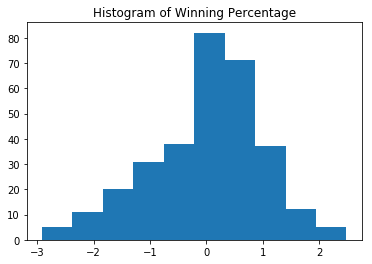

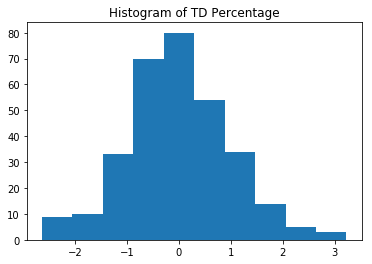

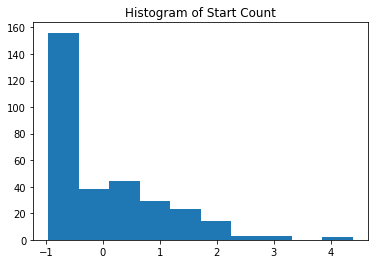

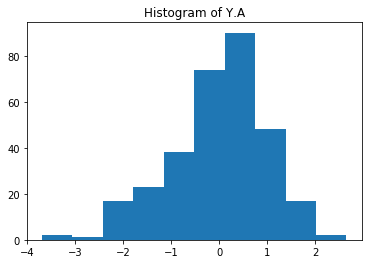

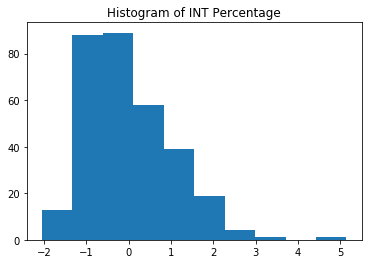

In [15]:
# Histogram of scaled winning percentage stats, not perfectly normal but not awful
plt.hist(scaled_cluster_stats['gs_wp'])
plt.title("Histogram of Winning Percentage")
plt.show()
plt.hist(scaled_cluster_stats['TD_pct'])
plt.title("Histogram of TD Percentage")
plt.show()
plt.title("Histogram of Start Count")
plt.hist(scaled_cluster_stats['start_count'])
plt.show()
plt.title("Histogram of Y.A")
plt.hist(scaled_cluster_stats['Y.A'])
plt.show()
plt.title("Histogram of INT Percentage")
plt.hist(scaled_cluster_stats['Int_pct'])
plt.show()

#### Looking at this histograms above, Y.A, TD_pct, and Winning Percentage look somewhat normally distributed. Int_pct and start count are skewed. I actually don't mind this because it makes me think a lot of the QBs who didn't play many games will be grouped together, which is fine, as that is a decent measure of success.

### K-Means clustering
#### Below, I take the retired QBs and cluster them in an unsupervised way into three tiers. I hope to get a good separation between 'good', 'average', and 'bad' qbs, using the statistics I looked at above. The tiers that the clustering algorithm will be used as a response variable in future analysis.

In [16]:
from sklearn.cluster import KMeans
clusters = 3
kmeans = KMeans(n_clusters = clusters, random_state = 1).fit(scaled_cluster_stats)

In [17]:
pd.options.mode.chained_assignment = None
scaled_cluster_stats['tier'] = kmeans.labels_ 
retired_qbs['tier'] = kmeans.labels_

#### Looking at the summary statistics of each cluster below, we see that the algorithm did a good job of separating the QBs into the tiers we desired. Cluster 0 is the 'good' qbs with the best Y/A, best TD%, the longest careers, and best Winning% (though the highest int% which is a bit surprising). Tier 1 is the worst QBs, with the lowest Y/A, , lowest winning%, and shortest careers. Tier 2 is in the middle.

In [18]:
for i in range(0,clusters):
    print(i)
    print(retired_cluster_stats[scaled_cluster_stats['tier'] == i].describe())

0
       start_count         Y.A      TD_pct     Int_pct       gs_wp
count   106.000000  106.000000  106.000000  106.000000  106.000000
mean    122.254717    7.188980    0.048418    0.044873    0.534546
std      59.010259    0.357329    0.007848    0.013885    0.092668
min      10.000000    6.404372    0.033822    0.022563    0.321429
25%      91.250000    6.928760    0.043171    0.033331    0.472560
50%     125.500000    7.156319    0.046979    0.043200    0.526794
75%     157.750000    7.422383    0.053207    0.053861    0.604871
max     319.000000    8.318486    0.072438    0.080685    0.797297
1
       start_count        Y.A     TD_pct    Int_pct      gs_wp
count    78.000000  78.000000  78.000000  78.000000  78.000000
mean     20.910256   5.941815   0.029789   0.053002   0.268118
std      12.698487   0.574127   0.008673   0.016675   0.131861
min      10.000000   4.328520   0.011338   0.025478   0.000000
25%      12.000000   5.521918   0.023665   0.040095   0.175889
50%      15.500

In [19]:
# assign each QB to the tier they were assigned to by the clustering algorithm.
qb_data_with_tiers = qb_data
qb_data_with_tiers = qb_data_with_tiers.set_index(['id']).join(retired_qbs['tier'])
retired_qb_with_tiers = qb_data_with_tiers[np.isnan(qb_data_with_tiers['tier']) == False]

### Random Forest Classifier

In [20]:
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
retired_qb_with_tiers.head() # we now have all their per-game data with their tier assigned as a column
retired_qb_with_tiers.index.name='id'

#### Function for getting a QB's summary stats for the first X games. This function does a lot of the work for analyzing how many games it takes to be able to accurately classify which tier a QB will fall into.

In [21]:
def get_stats_for_first_x_games(full_data, games):
    reduced_data = full_data[full_data['start_count'] <= int(games)] #get a QB's games through their first X starts
    sum_columns =['Cmp', 'Att','Yds','TD','Int', 'team_win','start_win'] # these are the columns we want the sums for for those first X games
    qb_totals = reduced_data.groupby('id')[sum_columns].sum() # get the sums
    qb_totals['total_game_starts'] = full_data.groupby('id')['start_count'].max() # get their total number of starts in their career
    qb_totals['total_games'] = [x if x < games else games for x in qb_totals['total_game_starts']] #if the total starts is less than the games asked for, use their # of career starts
    qb_totals['Cmp.'] = qb_totals['Cmp'] / qb_totals['Att'] # calculate completion % for their first x games
    qb_totals['Y.A'] = qb_totals['Yds'] / qb_totals['Att'] # calculate y/a for their first x games
    qb_totals['TD_pct'] = qb_totals['TD'] / qb_totals['Att']
    qb_totals['Int_pct'] = qb_totals['Int'] / qb_totals['Att']
    qb_totals['gs_wp'] = (qb_totals['start_win'] / qb_totals['total_games']).fillna(0) # get their winning % for their first x games
    qb_totals['tier'] = reduced_data.groupby('id')['tier'].max() # include their tier
    return(qb_totals)

### Modeling & K-Fold Cross Validation

#### The below is the meat of the analysis. The steps are as follows:
* Instantiate 5 splits for 5-Fold validation. The same splits will be used for each iteration
* Run a loop for 1-80 games considered. Basically, we are going to create a model where we look at the first X games, where X ranges from 1-80, to see how predictive those X games are towards determining which tier a qb ends up in.
* So starting with 1 game, we take each of the retired QBs and get their first game stats using the function we defined above.
* We split the QBs into 5 folds.
* We start with 4 of the folds to create a model, and one to test against to get a classification error. We are trying to predict which tier they end their careers in.
* Scale the regressors so theyre all on an even playing field as far as importance for the model.
* Use a random forest classifier on the 4 folds used for modeling. Use the fifth fold for making predictions based on the model created from the other 4 folds.
* Calculate the classification error of how predictive the first game was towards figuring out which tier they ended their careers in.
* Also calculate what i refer to as a 'bad classification' which is when the model predicts someone to be in tier 1 (bad qbs) when they actually ended up in tier 0 (very good qbs), or vice versa.
* Do the modeling/classification error calculation for each of the 5 folds, and average the classification error for that number of games.
* Repeat the process, but this time looking at how predictive the first 2 games were. Continue through the first 80 games, calculating average classification error for each number of games considered.

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 5, shuffle=True, random_state=10)
averages = list()
bad_averages = list()
reg_averages = list()
for i in np.arange(1,80):
    first_x_games = get_stats_for_first_x_games(retired_qb_with_tiers, i)
    first_x_games['tier_fact'] = first_x_games['tier'].astype('category')
    X = first_x_games[['Y.A', 'TD_pct', 'Int_pct','gs_wp']]
    y = first_x_games['tier_fact']
    errors = list()
    bad_errors = list()
    reg_errors = list()
    for train, test in kf.split(X):
        X_train =  X.iloc[train]
        X_test = X.iloc[test]
        y_train = y.iloc[train]
        y_test = y.iloc[test]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        reversefactor = dict(zip(range(3),["0","1","2"]))
        y_test = np.vectorize(reversefactor.get)(y_test)
        y_pred = np.vectorize(reversefactor.get)(y_pred)
        errors.append(sum(y_test != y_pred)/len(y_test))
        bad_errors.append((sum(y_pred[y_test == '1'] == '0') + sum(y_pred[y_test == '0'] == '1'))/len(y_test))
    averages.append(np.mean(errors))   
    bad_averages.append(np.mean(bad_errors))

#### Once we've calculated the classification error and 'bad error' rates, we plot them to see how it changed over each number of games considered. As expected we see an overall decreasing error rate for both types of error.

In [ ]:
plt.plot(np.arange(1,80), averages, bad_averages)
plt.title('Starts at Beginning of Career vs. Classification Error Rate')
plt.xlabel('Number of Starts Considered')
plt.ylabel('Error Rate')
plt.legend(['Total Error Rate', 'Bad Error Rate'])
plt.show()

#### At around 30 games, we have about 23% error rate - which is only slightly higher than the error rate at about 60 games. Thus, we say that after about 30 games, a team will have a pretty good idea about how a Quarterback's career will turn out, and that waiting an additional 30 games won't give them much more information.
#### The same can be said about 'bad' classification error rate. After 30 games, the likelihood of making a bad error is about 4%, and adding more games doesn't give too much information about a qb.

In [ ]:
plt.plot(np.arange(1,80), averages, bad_averages)
plt.title('Starts at Beginning of Career vs. Classification Error Rate')
plt.xlabel('Number of Starts Considered')
plt.ylabel('Error Rate')
plt.legend(['Total Error Rate', 'Bad Error Rate'])
plt.axhline(y=.23, color='black', linestyle = '--')
plt.axhline(y=.04, color='black', linestyle = '--')
plt.show()

## Predicting Which Tier Current QBs will End Up in
#### I will now use all of the retired QBs in order to create a model to make predictions about in which tier the current QBs will end their careers.

In [ ]:
predictions = list()
for index, row in current_qbs.iterrows():
    player_starts = row['start_count']
    retired_first_x_games = get_stats_for_first_x_games(retired_qb_with_tiers, player_starts)
    retired_first_x_games['tier_fact'] = retired_first_x_games['tier'].astype('category')
    X = retired_first_x_games[['Y.A', 'TD_pct', 'Int_pct','gs_wp']]
    y = retired_first_x_games['tier_fact']
    classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 2)
    classifier.fit(X, y)
    player_stats = row[['Y.A', 'TD_pct', 'Int_pct','gs_wp']]
    player_prediction = classifier.predict([player_stats])
    predictions.append(player_prediction.astype('int')[0])
current_qbs['predicted_tier'] = predictions

In [ ]:
def replace_tier_number_with_description(tier):
    if tier == 2:
        return('Average')
    if tier == 0:
        return('Great')
    if tier == 1:
        return('Scrub')

#### After Running the Classifier on the Current QBs, we can predict which tier they will end their careers in. I've marked the QBs who have had at least 30 starts because that is the threshold we established regarding when we can be about 77% confident in this prediction

In [ ]:
current_qbs['predicted_tier_cat'] = current_qbs.predicted_tier.apply(replace_tier_number_with_description)
current_qbs['over_30_games'] = ["*" if (x >=30) else '' for x in current_qbs['start_count']]
current_qbs[['name', 'predicted_tier_cat', 'over_30_games']]

### Conclusions

The results of the predictive model aligns pretty well with conventional wisdom. Certain hall-of-fame quarterbacks Tom Brady, Drew Brees, and Aaron Rodgers are classified as being great. Journeyman quarterbacks Ryan Fitzpatrick and Derek Anderson are classified as being average. And true scrub Blaine Gabbert is classified as such. 

There are a couple surprising results - I would expect Brock Osweiler to be considered a scrub, and Dak Prescott to be considered average. However, our classification error rates never hit 0%, so it doesn't surprise me that these seem slightly off - and perhaps I should just give these QBs more credit!